ESE545 HW2
Author: Shuairui YAO; Zhefu PENG

In [1]:
import tensorflow as tf
import keras
import sklearn
import numpy as np

Using TensorFlow backend.


## Problem 1
Make a new label vector, where each article has a 1 if it has been classified as CCAT and a −1 otherwise.
The first 100, 000 articles will be used for training and the remaining articles will be used to test. Split the data and labels into training and test sets.

In [75]:
from sklearn.datasets import fetch_rcv1 
rcv1 = fetch_rcv1()

In [76]:
target = rcv1['target'].todense()
label_vector = target[:,33].reshape(1,-1)[0].astype(np.int8)
label_vector[np.where(label_vector == 0)] = -1
label_vector = label_vector.tolist()[0]

In [4]:
train_set = rcv1['data'][0:100000,:]
test_set = rcv1['data'][100000:,:]

In [5]:
x_len = len(train_set[0,:].toarray()[0])
# train_set[0,:].toarray()[0]

## Problem 2
Using PEGASOS, train an SVM on the training articles. Make a plot of training error vs. number of iterations and include it in your Report. Make sure to justify the selection of any parameters (with evidence) in your Report. You may not use any libraries for this task.

In [123]:
def error_cal(w,x,y_real):
    y_predict = x.dot(w.transpose()).toarray().reshape(1,-1).tolist()[0]
    y_res = np.array(y_predict)*np.array(y_real)
    error = len(np.where(y_res<0)[0])/len(y_res)
    return error

In [122]:
def pegasos(lamb,batch_size,T):
    err_all = []
    w = csr_matrix([0]*x_len) # x_len = 47236
    errors = []
    for t in range(1,T+1):
        summ = csr_matrix([0]*x_len) # x_len = 47236
        randidx = random.sample(range(0, 100000), batch_size)
        for i in randidx:
            res = w.dot(train_set[i,:].transpose())*label_vector[i]
            if((res.todense()<1).tolist()[0][0]):
                # at_plus
                summ = summ + train_set[i,:]*label_vector[i]
        grad_t = lamb * w - summ/batch_size
        ita_t = 1/t/lamb
        wt_prime = w - ita_t*grad_t
        w = min(1,1/sqrt(lamb)/norm(wt_prime))*wt_prime
        if(t%10==0):
            error = error_cal(w,train_set,label_vector[0:100000])
            errors.append(error)
    return w, errors

In [9]:
from scipy.sparse import csr_matrix 
import random
from math import sqrt
from scipy.sparse.linalg import norm
import time

start = time.clock()

lambdas = [0.0001,0.0005,0.001,0.005,0.01,0.1]
batch_size = 50
T = 1000
err_all = []
for lamb in lambdas:
    w, err = pegasos(lamb,batch_size,T)
    err_all.append(err)
    
elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

minute used:  3.8875793666666665


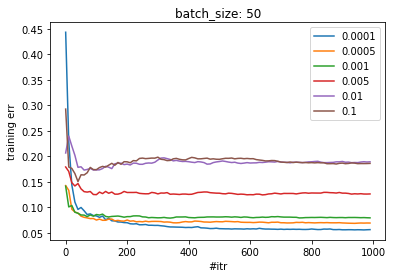

In [12]:
import matplotlib.pyplot as plt 
for i in range(len(lambdas)):
    plt.plot(range(0,T,10),err_all[i])
plt.legend(labels = lambdas, loc = 'best')
plt.xlabel('#itr')
plt.ylabel('training err')
plt.title("batch_size: %i" % batch_size)
plt.show()

In [13]:
start = time.clock()

lamb = 0.0001 # select lambda to be 0.0001
batch_size = [10,50,100,200,500,1000]
T = 1000
err_all = []
for b_size in batch_size:
    w, err = pegasos(lamb,b_size,T)
    err_all.append(err)
    
elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

minute used:  17.024597183333334


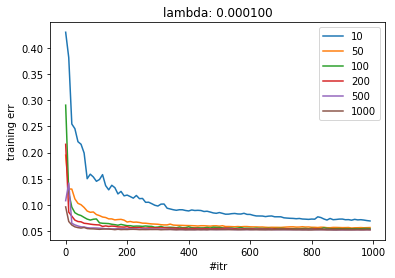

In [14]:
import matplotlib.pyplot as plt 
for i in range(len(batch_size)):
    plt.plot(range(0,T,10),err_all[i])
plt.legend(labels = batch_size, loc = 'best')
plt.xlabel('#itr')
plt.ylabel('training err')
plt.title("lambda: %f" % lamb)
plt.show()
# select batch size to be 50

## Problem 3 
Using AdaGrad, train a classifier on the training articles. Plot the training error vs. number of iterations in the same plot as above. Make sure to justify the selection of any parameters (with evidence) in your Report. You may not use any libraries for this task.

In [48]:
def adagrad(ita,lamb,batch_size,T):
    errors = []
    w = csr_matrix([0]*x_len) # x_len = 47236
    s = csr_matrix([1]*x_len)
    for t in range (1,T+1):
        summ = csr_matrix([0]*x_len) # x_len = 47236
        randidx = random.sample(range(0, 100000), batch_size)
        for i in randidx:
            res = w.dot(train_set[i,:].transpose())*label_vector[i]
            if((res.todense()<1).tolist()[0][0]):          
                summ = summ + train_set[i,:]*label_vector[i] # at_plus
        grad_t = lamb * w - summ/batch_size
        s_sqrt = np.sqrt(s + grad_t.multiply(grad_t)) # 1*47236 csr_matrix
        wt_prime = w - csr_matrix(csr_matrix([ita]*x_len)/s_sqrt).multiply(grad_t)
        w = min(1,1/sqrt(lamb)/norm(s_sqrt.multiply(wt_prime)))*wt_prime
        if(t%10==0):
            error = error_cal(w,train_set,label_vector[0:100000])
            errors.append(error)
    return w, errors

In [105]:
start = time.clock()

T = 1000
ita = 1/np.sqrt(T)
lamb = 0.0001
batch_size = [10,50,100,500,1000]
err_all = []
for b_size in batch_size:
    w, err = adagrad(ita,lamb,b_size,T)
    err_all.append(err)
    
elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

minute used:  20.452845549999985


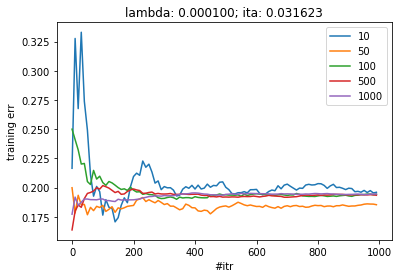

In [106]:
import matplotlib.pyplot as plt 
for i in range(len(batch_size)):
    plt.plot(range(0,1000,10),err_all[i])
plt.legend(labels = batch_size, loc = 'best')
plt.xlabel('#itr')
plt.ylabel('training err')
plt.title("lambda: %f; ita: %f" % (lambdas,ita))
plt.show()

In [107]:
start = time.clock()

T = 1000
ita = 2
lamb = 0.0001
batch_size = [10,50,100,500,1000]
err_all = []
for b_size in batch_size:
    w, err = adagrad(ita,lamb,b_size,T)
    err_all.append(err)
    
elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

minute used:  19.485907399999995


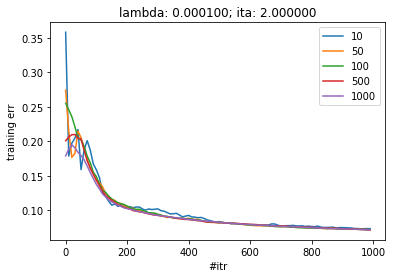

In [108]:
import matplotlib.pyplot as plt 
for i in range(len(batch_size)):
    plt.plot(range(0,1000,10),err_all[i])
plt.legend(labels = batch_size, loc = 'best')
plt.xlabel('#itr')
plt.ylabel('training err')
plt.title("lambda: %f; ita: %f" % (lambdas,ita))
plt.show()

In [110]:
start = time.clock()

T = 1000
ita = 0.1
lamb = 0.0001
batch_size = [10,50,100,500,1000]
err_all = []
for b_size in batch_size:
    w, err = adagrad(ita,lamb,b_size,T)
    err_all.append(err)
    
elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

minute used:  20.791909950000022


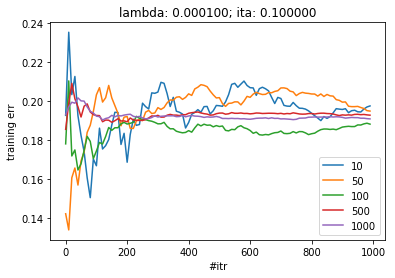

In [112]:
import matplotlib.pyplot as plt 
for i in range(len(batch_size)):
    plt.plot(range(0,1000,10),err_all[i])
plt.legend(labels = batch_size, loc = 'best')
plt.xlabel('#itr')
plt.ylabel('training err')
plt.title("lambda: %f; ita: %f" % (lamb,ita))
plt.show()

In [113]:
start = time.clock()

T = 1000
ita = 2
lambdas = [0.0001,0.001,0.01,0.1,1]
b_size = 50
err_all = []
for lamb in lambdas:
    w, err = adagrad(ita,lamb,b_size,T)
    err_all.append(err)
    
elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

minute used:  4.19208350000002


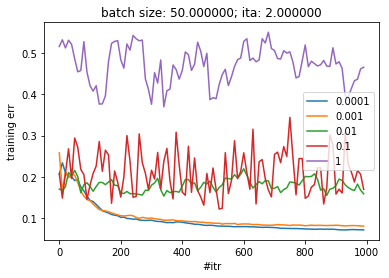

In [114]:
import matplotlib.pyplot as plt 
for i in range(len(batch_size)):
    plt.plot(range(0,1000,10),err_all[i])
plt.legend(labels = lambdas, loc = 'best')
plt.xlabel('#itr')
plt.ylabel('training err')
plt.title("batch size: %f; ita: %f" % (b_size,ita))
plt.show()

## Problem 4
You will now train a neural net on the training articles. We strongly suggest using keras for this task.

(a) Train neural nets over 5 epochs with 1, 2 and 3 hidden layers, each with 100 hidden units. Plot the training error and include it in your report.

In [79]:
# change the labels from -1 & 1 to 0 & 1
label_vector4 = np.array(label_vector)
label_vector4[label_vector4==-1]=0
label_vector4

array([0, 1, 1, ..., 1, 1, 0])

In [81]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import time

start = time.clock()

# 1 hidden layer (labels 0&1)
# create model
model = Sequential()
model.add(Dense(100, input_dim=x_len, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
# sgd = optimizers.SGD(lr=0.01,decay=0.0001)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy']) # binary_crossentropy
# Fit the model
h = model.fit(train_set, csr_matrix(label_vector4[0:100000]).transpose(), epochs=5, batch_size=50)

elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

Epoch 1/5
100000/100000 [==============================] - 82s 824us/step - loss: 0.6804 - acc: 0.5394
Epoch 2/5
100000/100000 [==============================] - 86s 857us/step - loss: 0.6486 - acc: 0.6219
Epoch 3/5
100000/100000 [==============================] - 85s 848us/step - loss: 0.5914 - acc: 0.8005
Epoch 4/5
100000/100000 [==============================] - 85s 854us/step - loss: 0.5060 - acc: 0.8782
Epoch 5/5
100000/100000 [==============================] - 88s 883us/step - loss: 0.4165 - acc: 0.8985
minute used:  16.07414221666668


dict_keys(['loss', 'acc'])


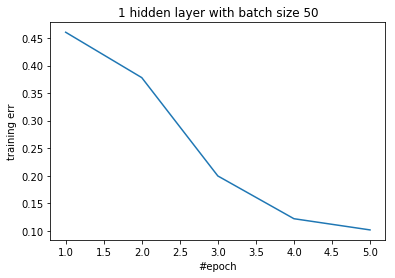

In [82]:
print(h.history.keys())

x = [1,2,3,4,5]
plt.plot(x,[1- acc for acc in h.history['acc']])
# plt.legend(labels = batch_size, loc = 'best')
plt.xlabel('#epoch')
plt.ylabel('training err')
plt.title("1 hidden layer with batch size 50" )
plt.show()

In [133]:
start = time.clock()

# 1 hidden layer (labels -1&1)
# create model
model = Sequential()
model.add(Dense(100, input_dim=x_len, activation='relu'))
model.add(Dense(1, activation='tanh'))
# Compile model
# sgd = optimizers.SGD(lr=0.01,decay=0.0001)
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy']) # binary_crossentropy
# Fit the model
h = model.fit(train_set, csr_matrix(label_vector[0:100000]).transpose(), epochs=5, batch_size=50)

elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

Epoch 1/5
100000/100000 [==============================] - 90s 896us/step - loss: 0.7615 - acc: 0.0531
Epoch 2/5
100000/100000 [==============================] - 624s 6ms/step - loss: 0.3699 - acc: 0.5469
Epoch 3/5
100000/100000 [==============================] - 338s 3ms/step - loss: 0.2659 - acc: 0.7441
Epoch 4/5
100000/100000 [==============================] - 97s 973us/step - loss: 0.2290 - acc: 0.8011
Epoch 5/5
100000/100000 [==============================] - 2097s 21ms/step - loss: 0.2089 - acc: 0.8280
minute used:  18.084913250000074


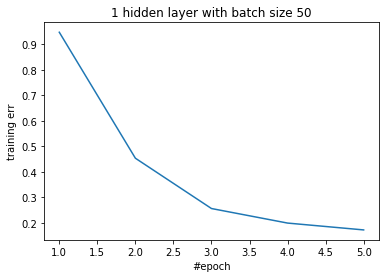

In [134]:
x = [1,2,3,4,5]
plt.plot(x,[1- acc for acc in h.history['acc']])
# plt.legend(labels = batch_size, loc = 'best')
plt.xlabel('#epoch')
plt.ylabel('training err')
plt.title("1 hidden layer with batch size 50" )
plt.show()

In [131]:
# 2 hidden layers (labels 0&1)
# create model
start = time.clock()

model = Sequential()
model.add(Dense(100, input_dim=x_len, activation='relu'))
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Fit the model
h2 = model.fit(train_set, label_vector4[0:100000], epochs=5, batch_size=50)

elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

Epoch 1/5
100000/100000 [==============================] - 96s 962us/step - loss: 0.6793 - acc: 0.5423
Epoch 2/5
100000/100000 [==============================] - 97s 973us/step - loss: 0.5956 - acc: 0.7611
Epoch 3/5
100000/100000 [==============================] - 92s 915us/step - loss: 0.3572 - acc: 0.9045
Epoch 4/5
100000/100000 [==============================] - 94s 943us/step - loss: 0.2250 - acc: 0.9228
Epoch 5/5
100000/100000 [==============================] - 93s 934us/step - loss: 0.1874 - acc: 0.9323
minute used:  16.318792566666648


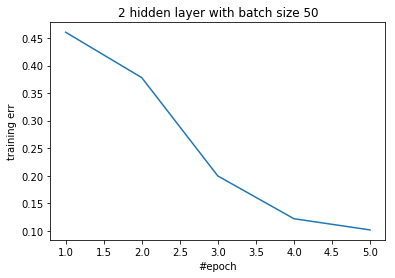

In [132]:
x = [1,2,3,4,5]
plt.plot(x,[1- acc for acc in h.history['acc']])
# plt.legend(labels = batch_size, loc = 'best')
plt.xlabel('#epoch')
plt.ylabel('training err')
plt.title("2 hidden layer with batch size 50" )
plt.show()

In [135]:
# 2 hidden layers (labels -1&1)
# create model
start = time.clock()

model = Sequential()
model.add(Dense(100, input_dim=x_len, activation='relu'))
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dense(1, activation='tanh'))
# Compile model
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
# Fit the model
h2 = model.fit(train_set, label_vector[0:100000], epochs=5, batch_size=50)

elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

Epoch 1/5
100000/100000 [==============================] - 95s 951us/step - loss: 0.6189 - acc: 0.2751
Epoch 2/5
100000/100000 [==============================] - 93s 928us/step - loss: 0.2240 - acc: 0.8175
Epoch 3/5
100000/100000 [==============================] - 92s 923us/step - loss: 0.1833 - acc: 0.8692
Epoch 4/5
100000/100000 [==============================] - 94s 941us/step - loss: 0.1655 - acc: 0.8870
Epoch 5/5
100000/100000 [==============================] - 93s 929us/step - loss: 0.1538 - acc: 0.8981
minute used:  16.132060683333354


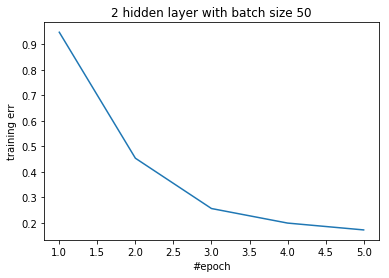

In [136]:
x = [1,2,3,4,5]
plt.plot(x,[1- acc for acc in h.history['acc']])
# plt.legend(labels = batch_size, loc = 'best')
plt.xlabel('#epoch')
plt.ylabel('training err')
plt.title("2 hidden layer with batch size 50" )
plt.show()

In [94]:
# 3 hidden layers (labels -1 & 1)
# create model
model = Sequential()
model.add(Dense(100, input_dim=x_len, activation='relu'))
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dense(1, activation='tanh'))
# Compile model
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
# Fit the model
h3 = model.fit(train_set, label_vector[0:100000], epochs=5, batch_size=50)

Epoch 1/5
100000/100000 [==============================] - 86s 862us/step - loss: 0.5290 - acc: 0.4276
Epoch 2/5
100000/100000 [==============================] - 83s 828us/step - loss: 0.1946 - acc: 0.8690
Epoch 3/5
100000/100000 [==============================] - 649s 6ms/step - loss: 0.1685 - acc: 0.8962
Epoch 4/5
100000/100000 [==============================] - 83s 831us/step - loss: 0.1551 - acc: 0.9084
Epoch 5/5
100000/100000 [==============================] - 182s 2ms/step - loss: 0.1444 - acc: 0.9156


dict_keys(['loss', 'acc'])


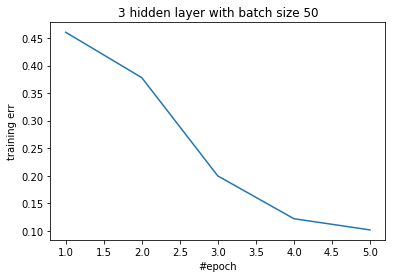

In [95]:
print(h3.history.keys())

x = [1,2,3,4,5]
plt.plot(x,[1- acc for acc in h.history['acc']])
# plt.legend(labels = batch_size, loc = 'best')
plt.xlabel('#epoch')
plt.ylabel('training err')
plt.title("3 hidden layer with batch size 50" )
plt.show()

In [137]:
# 3 hidden layers (labels 0 & 1)
# create model

start = time.clock()

model = Sequential()
model.add(Dense(100, input_dim=x_len, activation='relu'))
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Fit the model
h3 = model.fit(train_set, label_vector[0:100000], epochs=5, batch_size=50)

elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

Epoch 1/5
100000/100000 [==============================] - 103s 1ms/step - loss: -3.9048 - acc: 0.1375
Epoch 2/5
100000/100000 [==============================] - 95s 952us/step - loss: -7.4688 - acc: 0.3916
Epoch 3/5
100000/100000 [==============================] - 98s 982us/step - loss: -7.6730 - acc: 0.4076
Epoch 4/5
100000/100000 [==============================] - 89s 887us/step - loss: -7.7718 - acc: 0.4146
Epoch 5/5
100000/100000 [==============================] - 92s 915us/step - loss: -7.8423 - acc: 0.4184
minute used:  16.551502899999953


In [ ]:
x = [1,2,3,4,5]
plt.plot(x,[1- acc for acc in h.history['acc']])
# plt.legend(labels = batch_size, loc = 'best')
plt.xlabel('#epoch')
plt.ylabel('training err')
plt.title("3 hidden layer with batch size 50" )
plt.show()

(b) You will now try to design the best neural net you can for this task. Train several NNs, each with no more than hidden 6 layers. Create a table of the training error for different numbers of hidden units in your hidden layers and include it in your Report. You should try several different values of these parameters (at least 5 combinations), and justify your final selection (with evidence) in your Report. Your NN must take less than 10 minutes to train for any of your choices of parameters.

In [102]:
# 5 hidden layers
# hidden unit: 20,50,100
# create model
unit_no = [20,50,100]
h3 = []
for hidden in unit_no:
    model = Sequential()
    model.add(Dense(hidden, input_dim=x_len, activation='relu'))
    model.add(Dense(hidden, input_dim=hidden, activation='relu'))
    model.add(Dense(hidden, input_dim=hidden, activation='relu'))
    model.add(Dense(hidden, input_dim=hidden, activation='relu'))
    model.add(Dense(hidden, input_dim=hidden, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    # Fit the model
    h3.append(model.fit(train_set, label_vector4[0:100000], epochs=5, batch_size=50))

Epoch 1/5
100000/100000 [==============================] - 34s 341us/step - loss: 0.6650 - acc: 0.5724
Epoch 2/5
100000/100000 [==============================] - 32s 319us/step - loss: 0.2819 - acc: 0.9073
Epoch 3/5
100000/100000 [==============================] - 32s 320us/step - loss: 0.1728 - acc: 0.9365
Epoch 4/5
100000/100000 [==============================] - 31s 315us/step - loss: 0.1509 - acc: 0.9449
Epoch 5/5
100000/100000 [==============================] - 32s 319us/step - loss: 0.1406 - acc: 0.9490
Epoch 1/5
100000/100000 [==============================] - 42s 425us/step - loss: 0.6874 - acc: 0.5390
Epoch 2/5
100000/100000 [==============================] - 42s 418us/step - loss: 0.4959 - acc: 0.7920
Epoch 3/5
100000/100000 [==============================] - 41s 414us/step - loss: 0.1888 - acc: 0.9297
Epoch 4/5
100000/100000 [==============================] - 42s 418us/step - loss: 0.1584 - acc: 0.9418
Epoch 5/5
100000/100000 [==============================] - 42s 417us/step

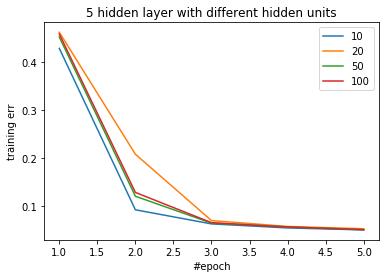

In [104]:
x = [1,2,3,4,5]
for i in range(len(h3)):
    plt.plot(x,[1- acc for acc in h3[i].history['acc']])
plt.legend(labels = unit_no, loc = 'best')
plt.xlabel('#epoch')
plt.ylabel('training err')
plt.title("5 hidden layer with different hidden units" )
plt.show()

In [119]:
# 5 hidden layers
# hidden unit: 20
# create model
unit_no = [20]
h3 = []
for hidden in unit_no:
    model = Sequential()
    model.add(Dense(hidden, input_dim=x_len, activation='relu'))
    model.add(Dense(hidden, input_dim=hidden, activation='relu'))
    model.add(Dense(hidden, input_dim=hidden, activation='relu'))
    model.add(Dense(hidden, input_dim=hidden, activation='relu'))
    model.add(Dense(hidden, input_dim=hidden, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    # Fit the model
    h3.append(model.fit(train_set, label_vector4[0:100000], epochs=5, batch_size=50))

Epoch 1/5
100000/100000 [==============================] - 42s 425us/step - loss: 0.6859 - acc: 0.5389
Epoch 2/5
100000/100000 [==============================] - 42s 415us/step - loss: 0.4654 - acc: 0.7970
Epoch 3/5
100000/100000 [==============================] - 42s 418us/step - loss: 0.1873 - acc: 0.9303
Epoch 4/5
100000/100000 [==============================] - 45s 454us/step - loss: 0.1571 - acc: 0.9418
Epoch 5/5
100000/100000 [==============================] - 45s 452us/step - loss: 0.1439 - acc: 0.9463


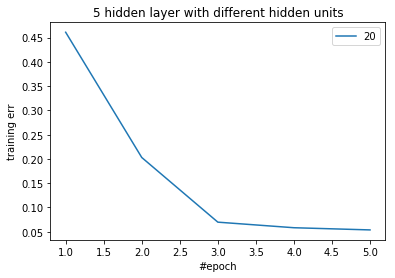

In [120]:
x = [1,2,3,4,5]
for i in range(len(h3)):
    plt.plot(x,[1- acc for acc in h3[i].history['acc']])
plt.legend(labels = unit_no, loc = 'best')
plt.xlabel('#epoch')
plt.ylabel('training err')
plt.title("5 hidden layer with different hidden units" )
plt.show()

## Problem 5
Evaluate your best SVM, AdaGrad classifier and NN from Problems 3-5 on the test articles 
and report the test error. 
You should use the parameters you selected previously. 
Which classifier did best? Why do you think that is?

In [125]:
# best PEGASOS
# w, err = pegasos(lamb,b_size,T)
start = time.clock()

w_pegasos, train_err = pegasos(0.0001,50,1000)
test_err = error_cal(w_pegasos,test_set,label_vector[100000:])

elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

minute used:  0.6209402333332643


In [126]:
test_err

0.06415261479754804

In [127]:
# best AdaGrad
# w, err = adagrad(ita,lamb,b_size,T)
start = time.clock()

w_adagrad, train_err_ada = adagrad(2,0.0001,50,1000)
test_err_ada = error_cal(w_adagrad,test_set,label_vector[100000:])

elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)
print(test_err_ada)

minute used:  0.8351269666665757
0.07454423109137524


In [128]:
# best NN
# 5 hidden layers
# hidden unit: 20
# create model
hidden = 20
model = Sequential()
model.add(Dense(hidden, input_dim=x_len, activation='relu'))
model.add(Dense(hidden, input_dim=hidden, activation='relu'))
model.add(Dense(hidden, input_dim=hidden, activation='relu'))
model.add(Dense(hidden, input_dim=hidden, activation='relu'))
model.add(Dense(hidden, input_dim=hidden, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Fit the model
h_best = model.fit(train_set, label_vector4[0:100000], epochs=5, batch_size=50)

Epoch 1/5
100000/100000 [==============================] - 40s 404us/step - loss: 0.6706 - acc: 0.5740
Epoch 2/5
100000/100000 [==============================] - 41s 406us/step - loss: 0.2954 - acc: 0.9055
Epoch 3/5
100000/100000 [==============================] - 42s 417us/step - loss: 0.1731 - acc: 0.9369
Epoch 4/5
100000/100000 [==============================] - 42s 416us/step - loss: 0.1540 - acc: 0.9434
Epoch 5/5
100000/100000 [==============================] - 41s 410us/step - loss: 0.1403 - acc: 0.9489


In [130]:
start = time.clock()

scores = model.evaluate(test_set,label_vector4[100000:])
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

elapsed = (time.clock()-start)/60
print("minute used: ",elapsed)

704414/704414 [==============================] - 172s 244us/step
Test loss: 0.15970506702175385
Test accuracy: 0.9401388955931563
minute used:  3.077528766666607
